In [180]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import warnings
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [181]:
data = pd.read_csv('dataset_57_hypothyroid.csv')
data.replace('?', np.nan, inplace=True)
# Параметры ниже константны (TBG = NaN)
data.drop(['TBG_measured', 'TBG'], axis=1, inplace=True)
data.dropna(subset=['Class'], axis=0, inplace=True)

In [182]:
data.shape

(3772, 28)

In [183]:
data.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... T3_measured  \
0        f               f              f                 f  ...           t   
1        f               f              f                 f  ...           t   
2        f               f              f                 f  ...           f   
3        f               f              f                 f  ...           t   
4        f               f              f                 f  ...           t   

    T3 TT4_measured  TT4 T4U_measured   T4U FTI_measured  FTI referral_source  \
0  2.5            t  125            t  1.14            t  109            SVHC   
1    2            t  102            f   NaN            f  NaN           other   
2  NaN            t  109            t  0.91            t  120           other   
3  1.9            t  175            f   NaN            f  NaN           other   
4  1.2            t   61            t  0.87            t   70             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 28 columns]

In [184]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='ignore')

In [154]:
report = ProfileReport(data)
report.to_notebook_iframe()

## Выводы по EDA

Target в выборке несбалансирован. Accuracy для метрики не подойдет. Так как задача касается здоровья, наилучшим вариантом будут метрики с несимметричными ошибками точность и полнота. Числовые значения будут заполены средним значением, категориальные most frequent. <br>
Категориальные признаки будут заменены с  использованием One-Hot encoder <br>
В данных также есть повторяющиеся строки, от которых следует избавиться

In [155]:
bool_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col][0] in ['t', 'f']]
for col in bool_cols:
    data[col] = data[col] == 't'

In [156]:
data.drop_duplicates()
y = data['Class']
data.drop('Class', axis = 1, inplace=True)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train)

In [190]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Pipeline для предобработки данных

### Состоит из:
<ul>
    <li>Заполнение пропусков в числовых и категориальных значений</li>
    <li>Кодирование категориальных признаков</li>
    <li>Далее Pipeline соберется в другой, содержащий модель</li>
</ul>

In [191]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_cols = [col for col in data.columns if data[col].dtype =='object']
num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]



preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
], remainder='passthrough')

In [192]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, precision_score, log_loss, f1_score


# логистическая регрессия без регуляризации
model = LogisticRegression(penalty='none')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

logistic_pipeline.fit(X_train, y_train)

preds = logistic_pipeline.predict(X_valid)
prob_preds=logistic_pipeline.predict_proba(X_valid)

new_c = [col for col in X_train.columns if X_train[col].dtype != 'object']
new_c.extend(logistic_pipeline['preprocessor'].transformers_[1][1]['encoder'].get_feature_names())

logloss  0.00020063220080254081
Полнота  1.0
Точность  1.0
F1  1.0


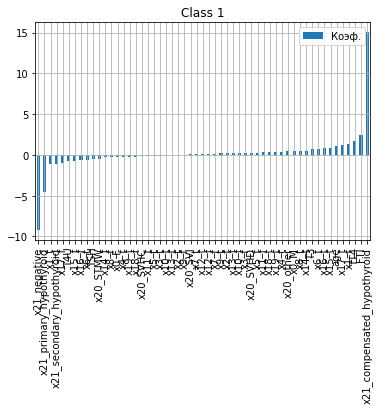

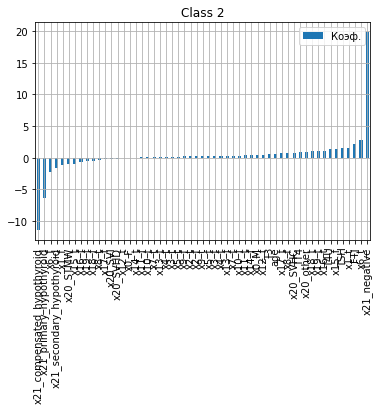

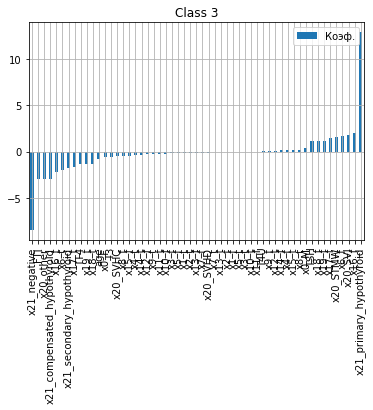

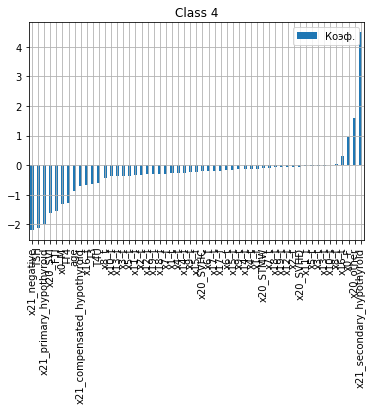

In [193]:
print('logloss ', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ', precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

## Логистическая регрессия с разными видами регуляризации


### L1

logloss 0.008969256022396918
Полнота  1.0
Точность  1.0
F1  1.0


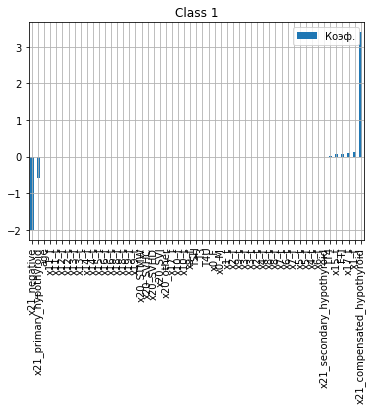

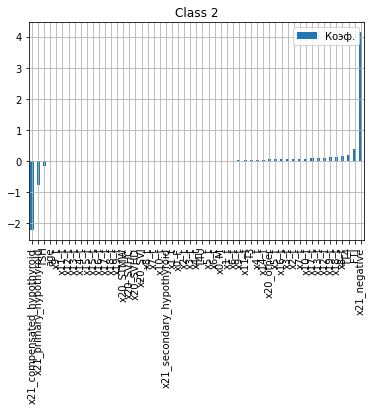

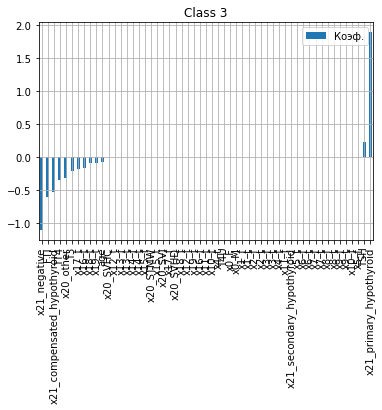

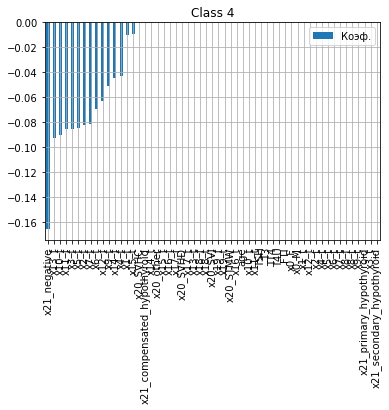

In [194]:
model = LogisticRegression(solver = 'saga' ,penalty='l1')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

Нелинейные изменения

Самым значим численным параметром, при регуляризации L1 , является T3 , добавил квадрат T3

In [195]:
X_train['T3^2'] = X_train['T3'] ** 2
X_valid['T3^2'] = X_valid['T3'] ** 2
X_test['T3^2'] = X_test['T3'] ** 2

In [196]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
    
])
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_cols = [col for col in X_train.columns if X_train[col].dtype =='object']
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]



preprocessor = ColumnTransformer(
transformers =[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols),
], remainder='passthrough')

new_c = [col for col in X_train.columns if X_train[col].dtype != 'object']
new_c.extend(logistic_pipeline['preprocessor'].transformers_[1][1]['encoder'].get_feature_names())

In [197]:
X_train['T3^2'].dtype

dtype('float64')

logloss 0.009668114057786966
Полнота  0.75
Точность  0.7496177370030581
F1  0.7498087222647284


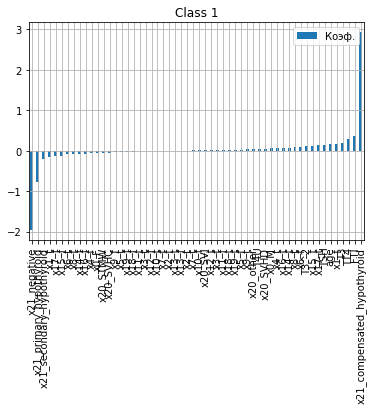

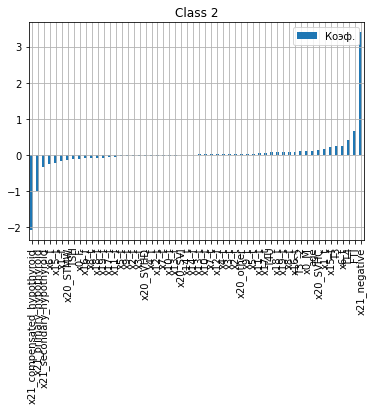

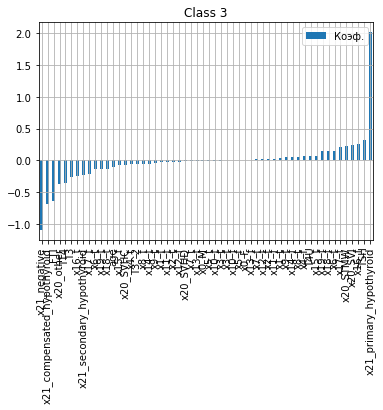

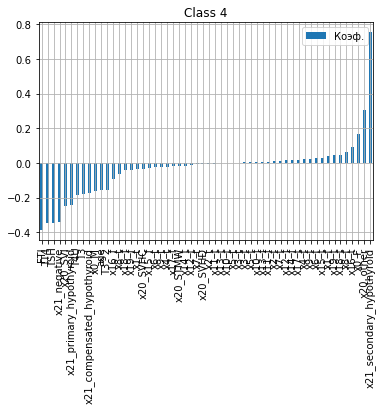

In [198]:
model = LogisticRegression(penalty='l2')
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_valid)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

###  Elastic net

logloss 0.011325884708752506
Полнота  0.75
Точность  0.7496177370030581
F1  0.7498087222647284


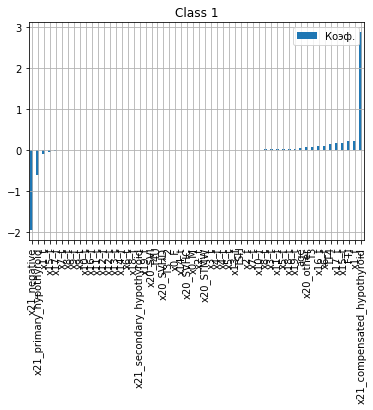

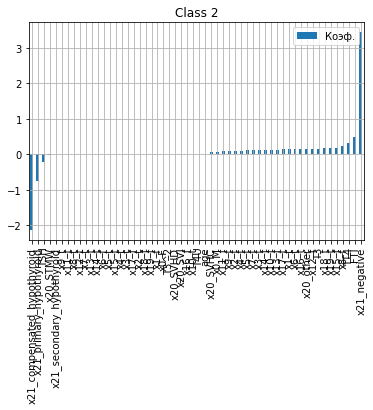

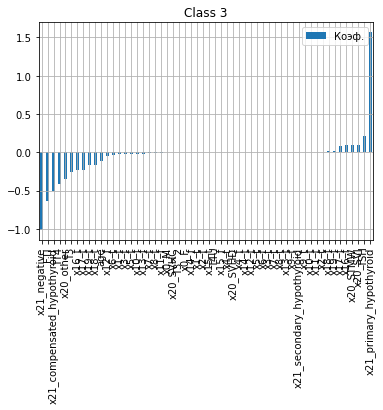

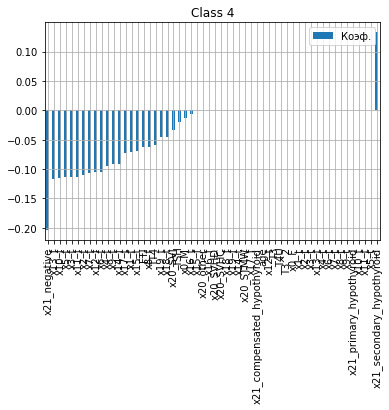

In [199]:
model = LogisticRegression(solver = 'saga' ,penalty='elasticnet', l1_ratio=0.5)
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
logistic_pipeline.fit(X_train, y_train)
preds = logistic_pipeline.predict(X_valid)
prob_preds = logistic_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))
for i in range(4):
    coef = pd.DataFrame(logistic_pipeline[1].coef_[i], new_c).sort_values(by=0)
    coef.columns = ['Коэф.']
    coef.plot.bar(grid=True, title='Сlass ' + str(i + 1))

## Выводы
Так как в задаче речь идет о здоровье человека, в этом случае будет выгодным взять модель с регуляризацией <b>L2</b>, так как этот вариант имеет наибольшую полноту, то есть наилучшим образом определяет больных. 

## Кросс-валидация для L2

In [200]:
from sklearn.model_selection import cross_val_score

for i in np.arange(0, 2, 0.1):
    model = LogisticRegression(penalty='l2', C=i)
    logistic_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ])
    scores = cross_val_score(logistic_pipeline, X_test, y_test, cv=5, scoring='f1_macro')
    print('C = ', round(i, 1), scores, np.mean(scores))

C =  0.0 [0.03350084 0.03350084 0.03350084 0.03367003 0.03045685] 0.03292587980494518
C =  0.1 [0.96200785 0.9147619  0.85429385 0.95142584 1.        ] 0.9364978909448824
C =  0.2 [0.96200785 1.         0.85429385 0.96200235 1.        ] 0.9556608111177362
C =  0.3 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  0.4 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  0.5 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  0.6 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  0.7 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  0.8 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  0.9 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  1.0 [0.96200785 1.         1.         0.96200235 1.        ] 0.9848020402589654
C =  1.1 [0.96200785 1.         1.         0.96200235 1.        

Наилучшие результаты возникают при C = 1 

# KNN

In [201]:
?KNeighborsClassifier

In [202]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

model = KNeighborsClassifier(algorithm='kd_tree')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.13060734756075726
Полнота  0.6315615960524077
Точность  0.7109692634363687
F1  0.6663453950118237


In [203]:
model = KNeighborsClassifier(algorithm='brute')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.13060734756075726
Полнота  0.6315615960524077
Точность  0.7109692634363687
F1  0.6663453950118237


In [204]:
model = KNeighborsClassifier(algorithm='ball_tree')
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

KNN_pipeline.fit(X_train, y_train)
preds=KNN_pipeline.predict(X_valid)
prob_preds = KNN_pipeline.predict_proba(X_valid)
print('logloss', log_loss(y_valid, prob_preds))
print('Полнота ', recall_score(y_valid, preds, average='macro'))
print('Точность ',precision_score(y_valid, preds, average='macro'))
print('F1 ', f1_score(y_valid, preds, average='macro'))


logloss 0.13060734756075726
Полнота  0.6315615960524077
Точность  0.7109692634363687
F1  0.6663453950118237


In [205]:
#%pip install shap

In [218]:
X_train_t

age       TSH        T3       TT4       T4U       FTI      T3^2  \
0     0.861093 -0.107800  0.864354 -0.410499  0.380530 -0.715427  0.521849   
1     1.293599 -0.086077 -0.166629 -0.036435 -0.354557  0.160561 -0.225436   
2     1.245543 -0.094766 -2.228596 -0.640693 -0.249544 -0.621571 -0.940231   
3     0.284418 -0.146901 -0.037757 -0.122758 -0.092026 -0.089721 -0.146240   
4     0.716924 -0.107800 -0.810994  0.423952 -0.722100  1.036549 -0.560496   
...        ...       ...       ...       ...       ...       ...       ...   
2116  0.572755 -0.142557  0.993227  0.596597  0.958098  0.004134  0.633536   
2117 -1.157270 -0.205771  0.735481  0.970661  0.380530  0.723696  0.414224   
2118  0.380530 -0.199036 -0.037757  1.431047  0.380530  1.192976 -0.146240   
2119 -2.406733 -0.206640 -0.037757  1.028209 -0.354557  1.380687 -0.146240   
2120  0.524699 -0.081733 -0.037757 -0.410499  0.433036 -0.715427 -0.146240   

      x0_F  x0_M  x1_f  ...  x19_t  x20_STMW  x20_SVHC  x20_SVHD  x20_SVI  \
0      1.0   0.0   1.0  ...    1.0       0.0       0.0       0.0      0.0   
1      1.0   0.0   1.0  ...    1.0       0.0       0.0       0.0      1.0   
2      1.0   0.0   0.0  ...    1.0       0.0       0.0       0.0      1.0   
3      1.0   0.0   1.0  ...    0.0       0.0       0.0       0.0      0.0   
4      1.0   0.0   1.0  ...    1.0       0.0       0.0       0.0      1.0   
...    ...   ...   ...  ...    ...       ...       ...       ...      ...   
2116   1.0   0.0   1.0  ...    1.0       0.0       0.0       0.0      1.0   
2117   0.0   1.0   1.0  ...    1.0       0.0       0.0       0.0      0.0   
2118   1.0   0.0   0.0  ...    1.0       0.0       0.0       0.0      0.0   
2119   1.0   0.0   0.0  ...    1.0       0.0       0.0       0.0      0.0   
2120   1.0   0.0   1.0  ...    1.0       0.0       0.0       0.0      1.0   

      x20_other  x21_compensated_hypothyroid  x21_negative  \
0           1.0                          0.0           1.0   
1           0.0                          0.0           1.0   
2           0.0                          0.0           1.0   
3           1.0                          0.0           1.0   
4           0.0                          0.0           1.0   
...         ...                          ...           ...   
2116        0.0                          0.0           1.0   
2117        1.0                          0.0           1.0   
2118        1.0                          0.0           1.0   
2119        1.0                          0.0           1.0   
2120        0.0                          0.0           1.0   

      x21_primary_hypothyroid  x21_secondary_hypothyroid  
0                         0.0                        0.0  
1                         0.0                        0.0  
2                         0.0                        0.0  
3                         0.0                        0.0  
4                         0.0                        0.0  
...                       ...                        ...  
2116                      0.0                        0.0  
2117                      0.0                        0.0  
2118                      0.0                        0.0  
2119                      0.0                        0.0  
2120                      0.0                        0.0  

[2121 rows x 56 columns]

In [217]:
import shap
shap.initjs()
model = KNeighborsClassifier()
X_train_t = pd.DataFrame(preprocessor.fit_transform(X_train))
X_valid_t = pd.DataFrame(preprocessor.transform(X_valid))
X_train_t.columns, X_valid_t.columns = new_c, new_c
model.fit(X_train_t, y_train)
preds = model.predict_proba(X_valid_t)
med = X_train_t.median().values.reshape((1, X_train_t.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values = explainer.shap_values(X_valid_t, nsamples=len(X_valid_t))
shap.force_plot(explainer.expected_value, shap_values, X_valid_t)

ValueError: cannot reshape array of size 943 into shape (708,1)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI',
                                  'T3^2']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'referral_source'])])


ValueError: Expected 2D array, got scalar array instead:
array=ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI',
                                  'T3^2']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'referral_source'])]).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.